# Multi-touch Multi-channel Attribution Model Using LSTM with Attention

This is an attribution model that uses LSTM with attention to assign weights to touchpoints. 

| Description | D001 (see [descriptions](https://github.com/ikatsov/tensor-house/blob/master/resources/descriptions.md)) |
|--|:--|
| Dataset | Criteo (see [datasets](https://github.com/ikatsov/tensor-house/blob/master/resources/datsets.md)) |
| Papers | Li2018, Ren2018 (see [papers](https://github.com/ikatsov/tensor-house/blob/master/resources/papers.md)) | 
| Installation | Download the dataset to 'data' folder |
| Libs | Keras, Scikit-learn, Pandas, Numpy |

### Data description
This dataset represents a sample of 30 days of Criteo live traffic data. Each line corresponds to one impression (a banner) that was displayed to a user. For each banner we have detailed information about the context, if it was clicked, if it led to a conversion and if it led to a conversion that was attributed to Criteo or not. Data has been sub-sampled and anonymized so as not to disclose proprietary elements.

Here is a detailed description of the fields (they are tab-separated in the file):

* timestamp: timestamp of the impression (starting from 0 for the first impression). The dataset is sorted according to timestamp.
* uid: a unique user identifier
* campaign: a unique identifier for the campaign
* conversion: 1 if there was a conversion in the 30 days after the impression (independently of whether this impression was last click or not)
* conversion_timestamp: the timestamp of the conversion or -1 if no conversion was observed
* conversion_id: a unique identifier for each conversion (so that timelines can be reconstructed if needed). -1 if there was no conversion
* attribution: 1 if the conversion was attributed to Criteo, 0 otherwise
* click: 1 if the impression was clicked, 0 otherwise
* click_pos: the position of the click before a conversion (0 for first-click)
* click_nb: number of clicks. More than 1 if there was several clicks before a conversion
* cost: the price paid by Criteo for this display (disclaimer: not the real price, only a transformed version of it)
* cpo: the cost-per-order in case of attributed conversion (disclaimer: not the real price, only a transformed version of it)
* time_since_last_click: the time since the last click (in s) for the given impression
* cat(1-9): contextual features associated to the display. Can be used to learn the click/conversion models. We do not disclose the meaning of these features but it is not relevant for this study. Each column is a categorical variable. In the experiments, they are mapped to a fixed dimensionality space using the Hashing Trick (see paper for reference).

### Key figures
* 2.4Gb uncompressed
* 16.5M impressions
* 45K conversions
* 700 campaigns

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#import keras

plt.style.use('ggplot')

In [2]:
# Initial data preparation

def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]

def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext
    
data_file = "sample_pcb.tsv"
df0 = pd.read_csv(data_file)

n_campaigns = 400

df1 = add_derived_columns(df0)
df2 = sample_campaigns(df1, n_campaigns)
df3 = filter_journeys_by_length(df2, 2)
df4 = balance_conversions(df3)
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

print(df6.shape[0])
print([df6[df6.conversion == 0].shape[0], df6[df6.conversion == 1].shape[0]])

122542
[61334, 61208]


## Last Touch Attribution

In [3]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df6)

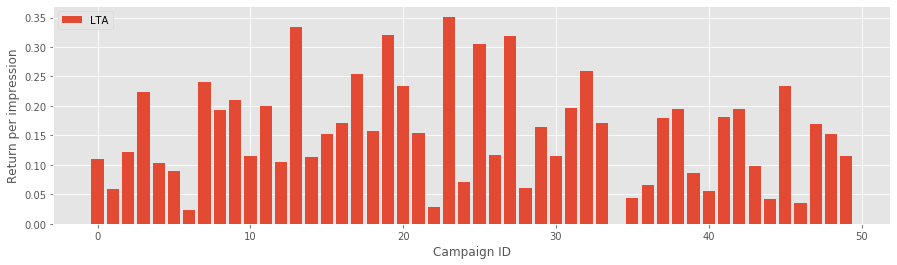

In [146]:
# Visualization of the attribution scores

campaign_idx = range(150,200)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

# Linear Touch Attribution

In [4]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
def linear_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    campaign_conversions = count_by_campaign(df_converted)
    print(type(campaign_conversions))
    return campaign_conversions / campaign_impressions
    
lin = linear_attribution(df6)

<class 'numpy.ndarray'>


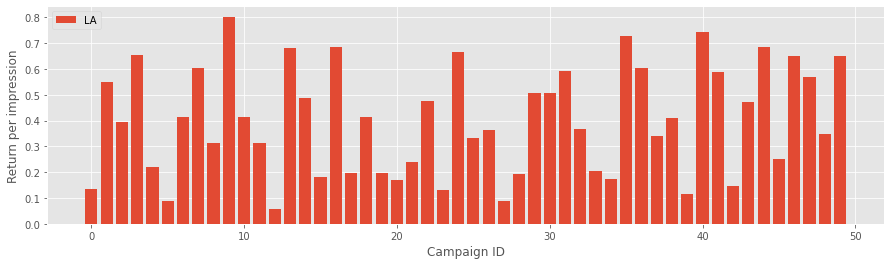

In [5]:
campaign_idx = range(150, 200)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lin[campaign_idx])), lin[campaign_idx], label='LA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [6]:
def count_by_campaign(df):
    counters = np.zeros(n_campaigns)
    for campaign_one_hot in df['campaigns'].values:
        campaign_id = np.argmax(campaign_one_hot)
        counters[campaign_id] = counters[campaign_id] + 1
    return counters

campaign_impressions = count_by_campaign(df)

df_converted = df[df['conversion'] == 1]
campaign_conversions = count_by_campaign(df_converted)
print(type(campaign_conversions))
return campaign_conversions / campaign_impressions

NameError: name 'df' is not defined

# Time Decay Attribution

In [7]:
x=df_converted[['jid','timestamp','campaign','conversion_timestamp','campaigns']].sort_values('jid')
#x[x['jid']=="9999748_25873601"]
x["diff"]=x['conversion_timestamp']-x['timestamp']
pd.to_numeric(x["diff"]).describe()
#Median Timestamp difference = 6.2 Days

NameError: name 'df_converted' is not defined

In [8]:
def count_by_campaign(df):
    counters = np.zeros(n_campaigns)
    for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
    return counters

count=count_by_campaign(df_converted)

NameError: name 'df_converted' is not defined

In [153]:
# min_max_scaler = MinMaxScaler()
# #pd.Series(min_max_scaler.fit_transform(x["diff"].values.reshape(-1,1)))
# # x['scaleddiff']=min_max_scaler.fit_transform(x[['diff']])
# # x["weight"]=np.exp(-x['scaleddiff'].astype(float))
# #df_converted["weight"]=df_converted["weight"].astype(float)
# counters = np.zeros(n_campaigns)
# for i,row in enumerate(x):
# #         campaign_id = np.argmax(campaign_one_hot)
# #         counters[campaign_id] = counters[campaign_id] + 1
#     campaign_id = np.argmax(x.iloc[i]["campaigns"])
#     counters[campaign_id] = counters[campaign_id] + x.iloc[i]["weight"]


In [9]:
def timedecay_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters

    def count_by_campaign2(df):
        counters = np.zeros(n_campaigns)
        for i,row in df.iterrows():
            campaign_id = np.argmax(row.loc["campaigns"])
            
            counters[campaign_id] = counters[campaign_id] + row.loc["weight"]
        return counters
                


        
    campaign_impressions = count_by_campaign(df)
    df_converted = df[df['conversion'] == 1]
    df_converted["diff"]=df_converted['conversion_timestamp']-df_converted['timestamp']
    
"""
Scaling the time difference between conversion timestamp and touchpoint timestamps
"""    

    df_converted['scaleddiff']=min_max_scaler.fit_transform(df_converted[['diff']])
    
"""
Determining weights using exponential decaying function :

Less difference in timestamp : More weight 

"""
    df_converted["weight"]=np.exp(-df_converted['scaleddiff'].astype(float))   
    campaign_conversions = count_by_campaign2(df_converted) 
    return campaign_conversions / campaign_impressions
    
td = timedecay_attribution(df6)


IndentationError: unexpected indent (<ipython-input-9-dc0f8884cee2>, line 29)

NameError: name 'td' is not defined

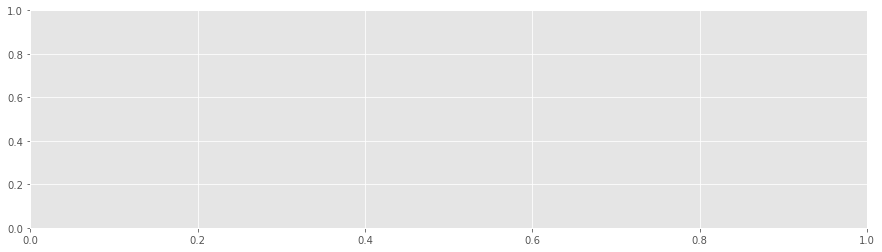

In [10]:
campaign_idx = range(150, 200)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(td[campaign_idx])), td[campaign_idx], label='TD' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

## Logistic Regression

In [201]:
def features_for_logistic_regression(df):

    def pairwise_max(series):
        return np.max(series.tolist(), axis = 0).tolist()
    
    aggregation = {
        'campaigns': pairwise_max,
        'cats': pairwise_max,
        'click': 'sum',
        'cost': 'sum',
        'conversion': 'max'
    }
    
    df_agg = df.groupby(['jid']).agg(aggregation)
    
    df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
    
    return (
        np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
        df_agg['conversion'].values
    )

In [202]:
x, y = features_for_logistic_regression(df6)
print(np.shape(x))

(145440, 1561)


In [203]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

In [204]:
# Quick sanity check
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
score = logisticRegr.score(x_test, y_test)
print(score)

0.8653396589658966


## Simulation

In [34]:
# Key assumption: If one of the campaigns in a journey runs out of budget, 
# then the conversion reward is fully lost for the entire journey
# including both past and future campaigns

def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    print(budgets)
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        #campaign_id=df.loc[i]['campaign']
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [154]:
# pitches = [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
# attributions = [lta, td]

# for i, pitch in enumerate(pitches):
#     for j, attribution in enumerate(attributions):
#         reward = simulate_budget_roi(df6, 10000, attribution**pitch)
#         print('{} {} : {}'.format(pitch, j, reward))

## First Touch Attribution Model

First touch attribution is the first of the single touchpoint attribution models. 
Pros : Its easy to explain and implement
       There are no confusing cases that could lead to errors or inconsistencies
Cons : It is a good approach only if we have consistent lead conversion rate across the channel.

In [11]:
np.seterr(divide='ignore', invalid='ignore')
def first_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
    
    return campaign_conversions / campaign_impressions
    
fta = first_touch_attribution(df6)

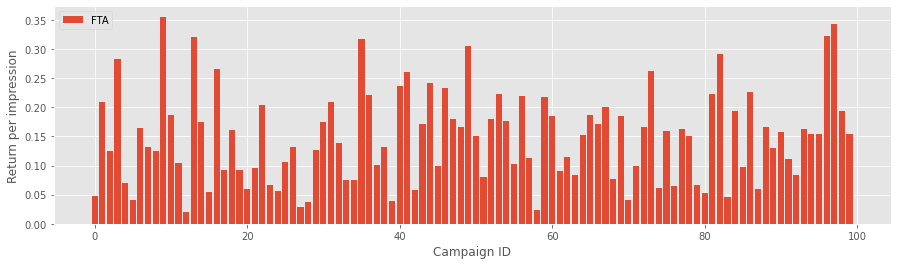

In [12]:
campaign_idx = range(150, 250)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

## U Shaped Attribution

It is a multi touch attribution which focuses on all the touchpoints but doesn't give equal credit to all the touch points instead focuses on the first and the touchpoint that is close to conversion

Pros : Its great for teams that focus on lead generation
Cons : It does not consider marketing efforts beyond lead generation

In [13]:
np.seterr(divide='ignore', invalid='ignore')
def U_shape_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
    
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion']==1]
    
    def calc_attr_val(click_nb, click_pos):
        default_attr = 0.5
        extreme_attr = 0.4
        intermittent_attr = 0.2
        
        if(click_nb == 2):
            return default_attr
        else:
            if(click_pos == click_nb-1 or click_pos == 0):
                return extreme_attr
            else:
                return intermittent_attr/(click_nb - 2)
            
    def U_Shape_attr_value(df_converted):   
        df_converted['U_Shape'] = df_converted.apply(lambda val: calc_attr_val(val.click_pos,val.click_nb),axis=1)
        return df_converted
    
    def U_Shape_by_campaign(df_converted):
        counters = np.zeros(n_campaigns)
        for idx in range(len(df_converted)):
            campaign_id = np.argmax(df_converted.iloc[idx,26])
            counters[campaign_id] = counters[campaign_id] + df_converted.iloc[idx,27]
        return counters
    
    df_converted = U_Shape_attr_value(df_converted)
    campaign_conversions = U_Shape_by_campaign(df_converted)
    
    return campaign_conversions/campaign_impressions

U_Shape_attr = U_shape_attribution(df6)

<ipython-input-13-5690cad1e47a>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_converted['U_Shape'] = df_converted.apply(lambda val: calc_attr_val(val.click_pos,val.click_nb),axis=1)


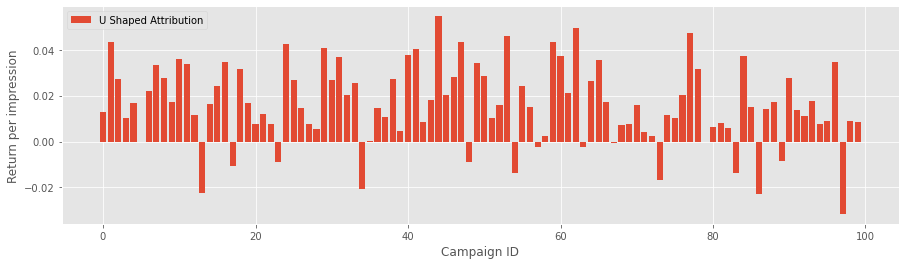

In [14]:
campaign_idx = range(150, 250)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(U_Shape_attr[campaign_idx])), U_Shape_attr[campaign_idx], label='U Shaped Attribution' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()